**Context**

ConnectWave has 50,000 customers. There rising churn rate among prepaid & short-term contract users. The current system is reactive in nature and cannot predict the customer churn. The management wants a data-driven monitoring system that can predict churn early and automatically notify the customer retention team through Slack.


**Problem Statement**

The company identifies churn only after customers leave. This leads to revenue loss and inefficient retention.

The model that predicts the customer churn can be considered a Binary classification problem with Target variable -> Churn (Yes/No)


**Objective**

Analyze customer behaviour and service usage patterns to identify major drivers of churn.

Build a predictive model to classify whether a customer is likely to churn.

Integrate Slack alerts to notify teams about high-risk customers.

Provide actionable insights to improve customer retention strategies.

**Data Understanding**

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("connectwave_customer_churn_dataset.csv")
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [2]:
df["Churn"].value_counts(normalize=True)

,proportion
Churn,
No,0.73463
Yes,0.26537


**Exploratory Data Analysis (EDA)**

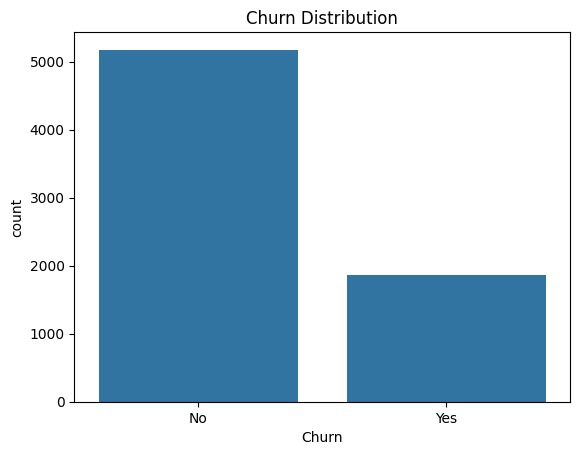

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Churn Distribution
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

The above figure represents that almost 27% customers churn

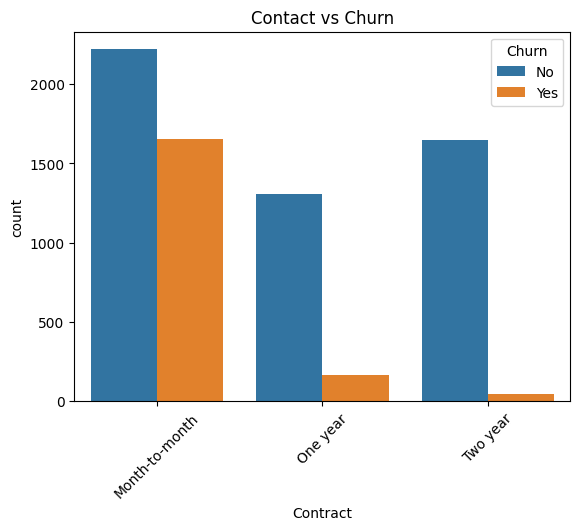

In [4]:
# Contact vs Churn
sns.countplot(x="Contract", hue="Churn", data=df)
plt.xticks(rotation=45)
plt.title("Contact vs Churn")
plt.show()

The above figure shows that Month-to-Month subscribed customers churn most of the time.

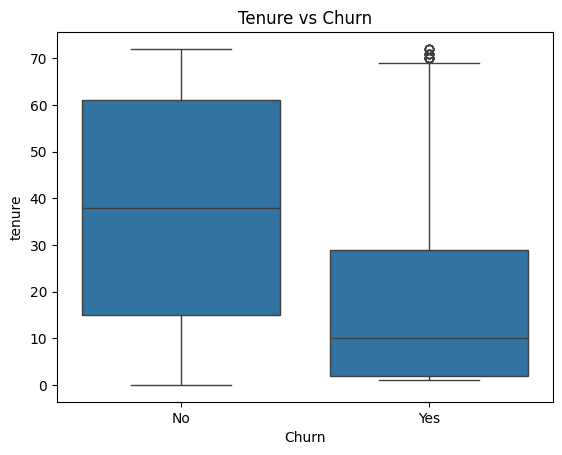

In [5]:
# Tenure vs Churn
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.show()

The above figure shows that customers who churn generally have much shorter tenure compared to those who stay.

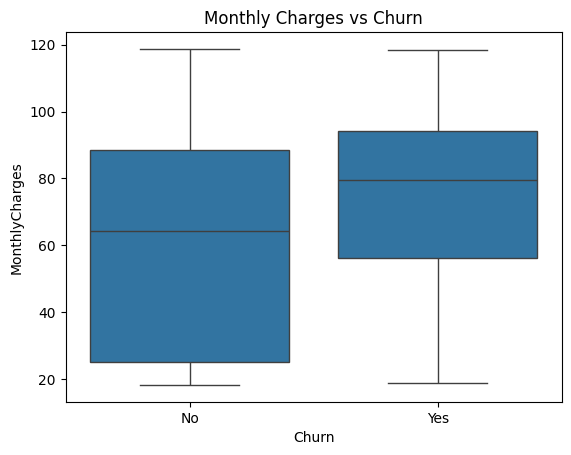

In [6]:
# Monthly Charges vs Churn
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

The above figure shows that customers who churn tend to have higher monthly charges than those who remain.

**Data Preprocessing**

In [7]:
# Converting TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [8]:
# Handling misisng values
df.fillna(df.median(numeric_only=True), inplace=True)

In [9]:
# Encode Target
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

**Feature Engineering**

In [10]:
# Customer value ratio
df["Charges_per_Tenure"] = df["TotalCharges"] / (df["tenure"] + 1)

In [11]:
# High Spender Flag
df["HighSpender"] = (df["MonthlyCharges"] > df["MonthlyCharges"].median()).astype(int)

In [12]:
# Contact type (One hot encoding)
df = pd.get_dummies(df, drop_first=True)

**Experiment Design**

Train-test split: 80-20

Models: Logistic Regression, Random Forest

Evaluation metrics: Accuracy, Precision, Recall, F1-score, ROC-AUC

**Data Preparation**

In [13]:
from sklearn.model_selection import train_test_split

X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

**Data Modeling**

In [14]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

**Model Evaluation**

In [16]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc

# Logistic Regression Evaluation
lr_pred = lr.predict(X_test)
lr_probs = lr.predict_proba(X_test)[:,1]

print("Logistic Regression Results")
print(classification_report(y_test, lr_pred))
print("ROC-AUC:", roc_auc_score(y_test, lr_probs))

# Random Forest Evaluation
rf_pred = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:,1]

print("Random Forest Results")
print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_probs))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

ROC-AUC: 0.8456431320881448
Random Forest Results
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.69      0.48      0.56       374

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

ROC-AUC: 0.836215092097445


Both model almost have similar results during evaluation. The recall for churn is moderate which means the model successfully identifies a meaningful portion of churners.

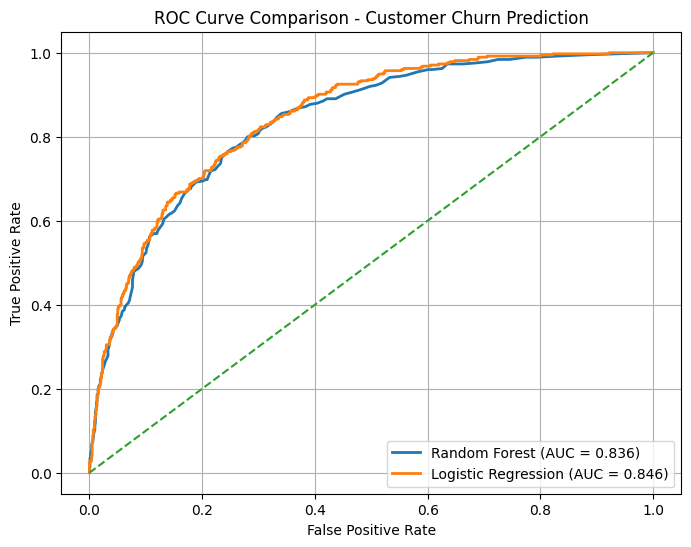

In [17]:
# Random Forest
rf_probs = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
auc_rf = auc(fpr_rf, tpr_rf)

# Logistic Regression
lr_probs = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
auc_lr = auc(fpr_lr, tpr_lr)

# Plot
plt.figure(figsize=(8,6))

plt.plot(fpr_rf, tpr_rf, lw=2,
         label=f"Random Forest (AUC = {auc_rf:.3f})")

plt.plot(fpr_lr, tpr_lr, lw=2,
         label=f"Logistic Regression (AUC = {auc_lr:.3f})")

# Baseline diagonal
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison - Customer Churn Prediction")
plt.legend()
plt.grid()
plt.show()

The ROC-AUC cuve is almost similar for both Logistic Regression as well as Random Forest.

**Model Explainability**

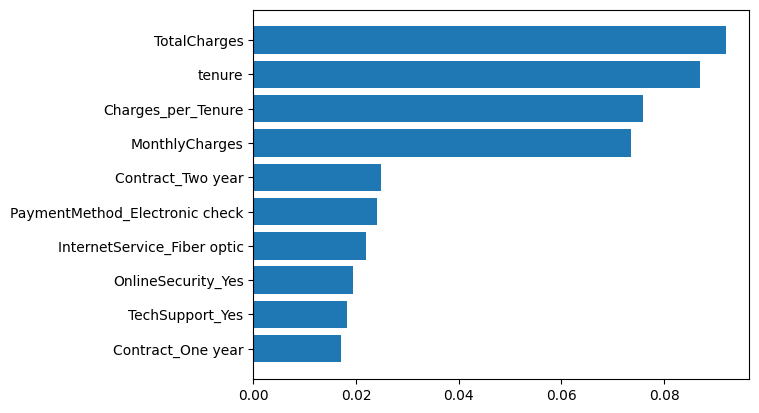

In [18]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]

plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

TotalCharges, tenure, and MonthlyCharges are the most influential factors in predicting churn, indicating that customer lifecycle stage and pricing play a major role in retention. Contract type and service features also impact churn, with long-term contracts and value-added services reducing churn risk.

In [19]:
# Slack Webhook integration for alerts
import requests
import json

webhook_url = "Your-webhook-URL"

def send_slack_alert(customer_id, churn_prob):
    message = {
        "text": f"⚠️ High Churn Risk Detected!\nCustomer ID: {customer_id}\nRisk Score: {round(churn_prob,2)}"
    }
    requests.post(webhook_url, data=json.dumps(message))

In [20]:
probs = rf.predict_proba(X_test)[:,1]

high_risk = X_test[probs > 0.75]

for idx in high_risk.index:
    send_slack_alert(idx, probs[list(X_test.index).index(idx)])

In [21]:
import joblib
joblib.dump(rf, "churn_model.pkl")

['churn_model.pkl']

**Recommendations**

Based on the results (TotalCharges, Tenure, Charges_per_Tenure, MonthlyCharges and Contract type) dominates the Churn output. The recommendations linked to the model insights is given below:

*Strengthen Early Customer Retention*: Tenure is one of the strongest churn predictors, with newer customers being most at risk. The company should implement a structured 90-day onboarding and engagement program with proactive check-ins and early incentives. HR should train and incentivize customer support teams to focus on improving first-year retention rates.

*Promote Long-Term Contracts*: Customers on month-to-month contracts are significantly more likely to churn than those on annual or two-year plans. The company should offer targeted discounts and benefits to encourage long-term contract conversions. HR can support this by training sales teams in retention-focused selling and rewarding successful contract upgrades.

*Address Pricing Sensitivity*: High monthly charges and higher cost relative to tenure increase churn risk. The company should provide flexible pricing options, bundle optimization, and proactive billing reviews for high-risk customers. HR should train staff in handling pricing objections and incentivize successful customer retention efforts.

*Operationalize Predictive Churn Intervention*: The Random Forest model effectively identifies high-risk customers, enabling proactive retention strategies. The company should integrate churn risk scoring into daily operations and initiate early outreach for at-risk customers. HR should develop a churn response playbook and align employee KPIs with churn reduction goals.